# HMM Composition with Multiple Sequences

In [9]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns

import scipy 
#import editdistance
import sklearn.metrics
import statsmodels.api as sm

%matplotlib inline 

In [10]:
## Helper functions for working with note pitch representation

## Convert from pitch representation (integers 0-127) to integers (0-max)
## x is the input vector of notes and code is a vector of the unique pitches in x
def encode(x, code):
    output = np.array([int(np.where(code == x[i])[0]) for i in range(0, len(x))])
    return output


## Reverses the function encode
## x is the vector of pitches to decode and code is a vector of the unique pitches in x before it was encoded
def decode(x, code):
    output = np.zeros(len(x))
    for i in range(0, len(x)):
        output[i] = code[x[i]]
    return output

## Function to convert the values in array to the nearest values in the array value
## Used to convert continues TVAR generated pitches to closest integer values for MIDI representation
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


## Function to create a matrix of notes and times representing the input piece as a matrix
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## met_mat output is a matrix where columns correspond to the time stamp of notes, one column for each min_note
##    duration for the entire piece and the rows are the note pitches, values in the matrix are 1 for the duration
##    of a note when it is played and 0 when it is not played
def create_matrix(time, notes, velocity, measures, min_note, num):
    met_mat = pd.DataFrame(np.zeros(shape = (len(np.unique(notes)), int(measures)*num), dtype = int))
    met_mat.index = np.unique(notes)[::-1]
    met_mat.columns = np.arange(0, min_note*num*measures, min_note)[:int(measures)*num]
    max_time = met_mat.columns[-1]
    for i in np.unique(notes):
        on = time[np.intersect1d(np.where(notes == i), np.where(velocity > 0) )]
        off = time[np.intersect1d(np.where(notes == i), np.where(velocity == 0) )]
        if len(off) % 2 !=0 or len(on) %2 !=0:
            off = np.append(off, max_time)
        for j in range(len(on)):
            met_mat.loc[i, on[j]:off[j]] = 1
    return(met_mat)

## Function to calculate the musical metrics of generated pieces
## met_mat is the output from create_matrix()
## harmonic ints is a vector of length 12 corresponding to the counts of each type of harmonic interval in the piece considered
## melodic ints is a vector of length 12 corresponding to the counts of each type of melodic interval in the piece considered
## percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals
def musical_metrics(met_mat):
    perfect = np.array([0,5,7])
    imperfect = np.array([3,4,8,9])
    dissonant = np.array([1,2,6,10,11])
    major_scale = np.array([2,2,1,2,2,2,1])
    harmonic_ints = np.zeros(12)
    c = 0
    max_notes = np.max(np.sum(met_mat, axis = 0))
    melodic = np.zeros(shape = (max_notes, len(met_mat.columns)))
    for col in met_mat.columns:
        chord = np.array(met_mat.index[np.where(met_mat[col] == 1)[0]])[::-1]
        if len(chord) > 0:
            intervals = np.diff(chord)
            intervals[intervals >= 12] = intervals[intervals >= 12] % 12
            harmonic_ints[intervals.astype(int)] +=1
            melodic[:len(chord), c] = chord
            c+= 1
    melodic_ints = list()
    for t in range(melodic.shape[1] - 1):
        m1 = melodic[melodic[:,t] > 0, t]
        m2 = melodic[melodic[:,t+1] > 0, t+1]
        melodic_ints.append(np.unique([abs(i-j) %12 for i in m1 for j in m2]))

    u = np.unique(np.hstack(melodic_ints), return_counts=True)
    m_ints = np.zeros(12)
    m_ints[u[0].astype(int)] = u[1].astype(int)

    h_total = np.sum(harmonic_ints)
    m_total = np.sum(m_ints)

    h_per = np.sum(harmonic_ints[perfect])/h_total
    h_imp = np.sum(harmonic_ints[imperfect])/h_total
    h_dis = np.sum(harmonic_ints[dissonant])/h_total

    m_per = np.sum(m_ints[perfect])/m_total
    m_imp = np.sum(m_ints[imperfect])/m_total
    m_dis = np.sum(m_ints[dissonant])/m_total

    percentage = np.array([h_per, h_imp, h_dis, m_per, m_imp, m_dis])

    return(harmonic_ints, m_ints, percentage)

## Calculate the empirical entropy of the input data and output as a vector in entropy
def ent(data):
    p_data= np.unique(data, return_counts = True)[1]/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy


## Function to compare an original piece to a generated piece and calculate metrics
## old_notes is a vector of the original piece's note pitches
## new_notes is a vector of the generated piece's note pitches
## Returns the empirical entropy, mutual information and edit distance between the original piece and the new, generated piece
##        also returns the count of unique notes in the generated piece, normalized by the total number of notes
def originality_metrics_comparison(old_notes, new_notes):
    # Calculate entropy
    entropy = ent(new_notes)

    # Calculate edit distance
    edit_dist = editdistance.eval(old_notes, new_notes)/len(old_notes)

    # Calculate mutual info
    mutual_info = sklearn.metrics.mutual_info_score(old_notes, new_notes)

    k = len(np.unique(old_notes))
    possibleNotes = np.unique(old_notes)    
    # Calculate note counts
    unique_new_notes, note_counts = np.unique(new_notes, return_counts = True)

    if len(unique_new_notes) != k:
        add_notes = list(set(possibleNotes) - set(unique_new_notes))
        for i in add_notes:
            if np.where(possibleNotes == i)[0] > len(note_counts):
                note_counts = np.append(note_counts, np.where(possibleNotes == i)[0], 0)
            else:
                note_counts = np.insert(note_counts, np.where(possibleNotes == i)[0], 0)
    note_counts = note_counts/len(old_notes)
    return(entropy, mutual_info, edit_dist, note_counts)


## Function to calculate the ACF and PACF out to lag 40
## new_ntoes is the input vector of note pitches
## note_acf is a vector of length 41 of the ACF values and note_pacf is a vector of length 41 of the PACF values
def time_metrics(new_notes):   
    #Calculate ACF/PACF out to lag 40
    note_acf = sm.tsa.stattools.acf(new_notes)
    try:
        note_pacf = sm.tsa.stattools.pacf(new_notes)
    except np.linalg.linalg.LinAlgError as err:
        note_pacf = sm.tsa.stattools.pacf(new_notes)

    return(note_acf, note_pacf)


## Function to calculate all metrics
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## output is a vector of the calculated metrics:
##        entropy is the empirical entropy of new_notes
##        mutual_info is the mutual information between old_notes and new_notes
##        edit_dist is the edit distance between old_notes and new_notes
##        harmonic_ints is a vector of length 12 of the count of harmonic intervals of each type in new_notes
##        melodic_ints is a vector of length 12 of the count of melodic intervals of each type in new_notes
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
##       note_counts is a vector of length equal to the number of unique pitches in old_notes with a normalized count of pitches
##           in new_notes
##       note_acf is a vector of length 41 with the acf of new_notes
##       note_pacf is a vector of length 41 with the pacf of new_notes
## Note: time is the same for old_notes and new_notes, as this is not changed between the original and generated pieces
##  (likewise, measures, min_note and num are the same for old_notes and new_notes)
def calc_metrics(time, old_notes, new_notes, velocity, measures, min_note, num):
    met_mat = create_matrix(time, new_notes, velocity, measures, min_note, num)
    harmonic_ints, m_ints, percentage = musical_metrics(met_mat)
    entropy, mutual_info, edit_dist, note_counts = originality_metrics_comparison(old_notes, new_notes)
    note_acf, note_pacf = time_metrics(new_notes)
    return(np.hstack((np.array([entropy, mutual_info, edit_dist]), 
           harmonic_ints, m_ints, percentage, note_counts, note_acf, note_pacf)))

In [11]:
## Function to pre-process input CSV of original song into form that can be used for modeling and metrics
## Assumes original piece's MIDI file has been converted to a CSV using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5
## input_filename = name of original csv
## output_filename = name of new csv to save generated piece to
## Outputs:
##         quarter_note = number of time steps corresponding to 1 quarter note
##         num = numerator in key signature
##         denom = denominator in key signature
##         key = key signature of piece, integer between -7 and 7 where 0 is C Major
##         measures = number of measures in input piece
##         time = vector of time stamps at which notes occurr
##         notes = vector of note pitches (integers 0-127)
##         velocity = "volume" of each note pitch, 0 = note off, length of time is the same as length of notes and velocity
##         song = pandas dataframe to use for output generated pieces, retains formatting expected by MIDI-CSV
##         song.index = index of original song dataframe

## See http://www.fourmilab.ch/webtools/midicsv/#midicsv.5 for a discussion of MIDI and CSV formats

class pre_process(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
     
   
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = song.iloc[r, 3].values.astype(int)[0]
        denom = song.iloc[r, 4].values.astype(int)[0]**2
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
       
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int)
        time2 = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, time2, notes, velocity, song, song_model.index)

## Pre-Process Multiple Sequences

- Create ragged array of notes
- Each ROW is a piece/unique sequence

In [12]:
# Key = 0 is C major, transpose all pieces to C major
# Key ranges from -7 (each flat below C) to + 7 (each sharp above C)

def transpose(key, notes):
    notes_transpose = -key + notes # get key to 0
    return(notes_transpose)

In [22]:
def multiple_process(file_list, min_note_list):
    ## Read in each piece and store information
    quarter_list = list()
    key_list = list()
    time_list = list()
    metrics_time = list()
    note_list = list()
    transposed = list()
    velocity_list = list()
    encoded_notes = list()


    for i in range(len(file_list)):
        quarter_note, num, denom, key, measures, time, time2,\
                notes, velocity, song, ind = pre_process(file_list[i], min_note_list[i]).read_process()
        quarter_list.append(quarter_note)
        key_list.append(key)
        time_list.append(time)
        metrics_time.append(time2)
        note_list.append(notes)
        # Transpose
        tNotes = transpose(key, notes)
        transposed.append(tNotes)
        velocity_list.append(velocity)
        print(file_list[i])
    
    
    
    
    ## All sequences need to be encoded to same reference
    possibleNotes = np.unique(np.concatenate([np.unique(transposed[i]) for i in range(len(file_list))]).ravel())
    encoded_notes = [encode(transposed[i], possibleNotes) for i in range(len(file_list))]
    
    
    T = np.max([len(n) for n in transposed])
    N = len([len(n) for n in transposed])
    ## ragged array of encoded pieces
    mat_pieces = np.zeros((N, T), dtype = int)

    for i in range(N):
        curr = encoded_notes[i]
        mat_pieces[i, :len(curr)] = curr
        
    return(mat_pieces, quarter_list, key_list, time_list, note_list, transposed, velocity_list, encoded_notes,
          possibleNotes, metrics_time)


In [23]:
file_list = ['OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv',
             'OriginalCSV/carol-of-the-bells.csv',
             'OriginalCSV/deutschlandlied.csv',
             'OriginalCSV/god-rest-you-merry-gentlemen.csv',
             'OriginalCSV/greensleeves.csv',
             'OriginalCSV/hark-the-herald-angels-sing.csv',
             'OriginalCSV/Jupiter.csv', 
             'OriginalCSV/in-the-bleak-midwinter.csv', 
             'OriginalCSV/muss_1_format0.csv', 
             'OriginalCSV/old-100th.csv', 
             'OriginalCSV/once-in-royal.csv', 
             'OriginalCSV/pachelbel.csv', 
             'OriginalCSV/shall-we-gather-at-the-river.csv', 
             'OriginalCSV/Songwithoutwords06.csv', 
             'OriginalCSV/swing-low-sweet-chariot.csv', 
             'OriginalCSV/the-blue-danube-piano.csv', 
             'OriginalCSV/Third-Mode-Melody.csv', 
             'OriginalCSV/twinkle-twinkle-little-star.csv',
             'OriginalCSV/we-three-kings-keyboard.csv',
             'OriginalCSV/when-johnny-comes-marching-home.csv']
min_note_list = [128, 128, 128, 128, 64, 128, 64, 128, 240, 256, 128, 64, 64, 64, 128, 256, 256, 256, 64, 128]

In [24]:
len(min_note_list)

20

In [26]:
mat_pieces, quarter_list, key_list, time_list, note_list, transposed, velocity_list, encoded_notes, \
          possibleNotes, metrics_time = multiple_process(file_list, min_note_list)

OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv
OriginalCSV/carol-of-the-bells.csv
OriginalCSV/deutschlandlied.csv
OriginalCSV/god-rest-you-merry-gentlemen.csv
OriginalCSV/greensleeves.csv
OriginalCSV/hark-the-herald-angels-sing.csv
OriginalCSV/Jupiter.csv
OriginalCSV/in-the-bleak-midwinter.csv
OriginalCSV/muss_1_format0.csv
OriginalCSV/old-100th.csv
OriginalCSV/once-in-royal.csv
OriginalCSV/pachelbel.csv
OriginalCSV/shall-we-gather-at-the-river.csv
OriginalCSV/Songwithoutwords06.csv
OriginalCSV/swing-low-sweet-chariot.csv
OriginalCSV/the-blue-danube-piano.csv
OriginalCSV/Third-Mode-Melody.csv
OriginalCSV/twinkle-twinkle-little-star.csv
OriginalCSV/we-three-kings-keyboard.csv
OriginalCSV/when-johnny-comes-marching-home.csv


In [27]:
possibleNotes

array([31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 86])

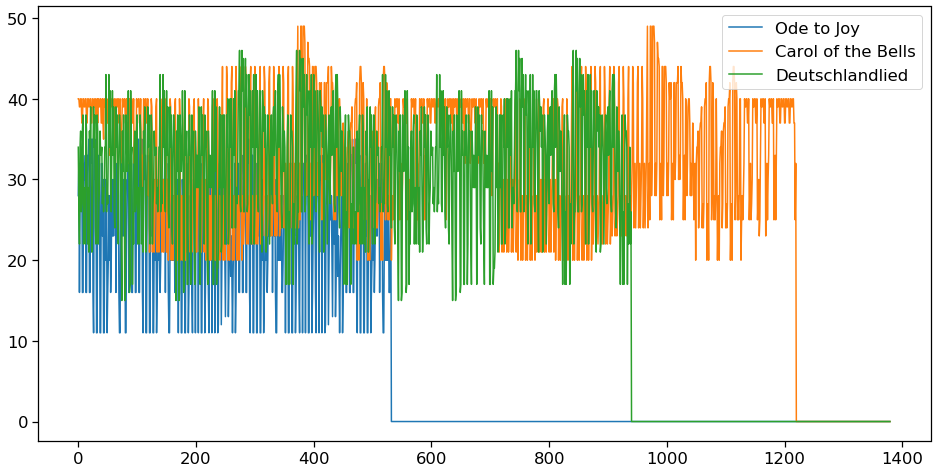

In [33]:
plt.figure(figsize = (16,8))
plt.plot(mat_pieces[0, :], label = "Ode to Joy")
plt.plot(mat_pieces[1, :], label = "Carol of the Bells")
plt.plot(mat_pieces[2, :], label = "Deutschlandlied")
plt.legend(loc = "upper right")
pass

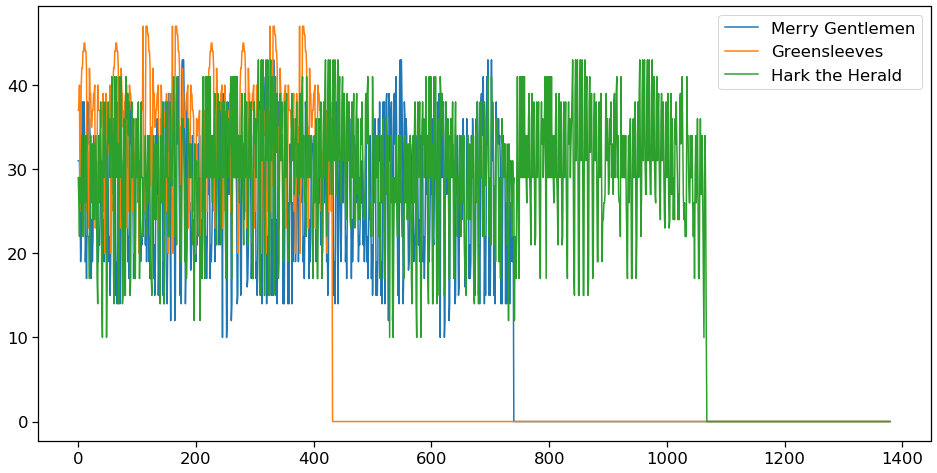

In [35]:
plt.figure(figsize = (16,8))
plt.plot(mat_pieces[3, :], label = "Merry Gentlemen")
plt.plot(mat_pieces[4, :], label = "Greensleeves")
plt.plot(mat_pieces[5, :], label = "Hark the Herald")
plt.legend(loc = "upper right")
pass

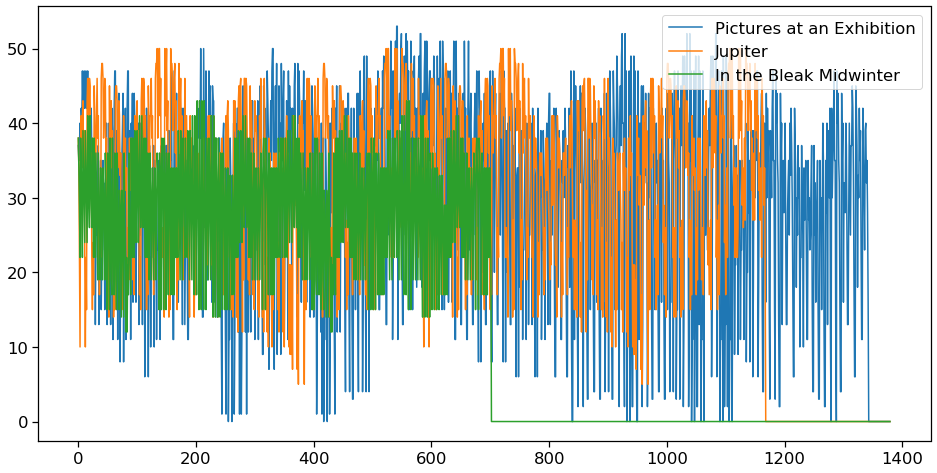

In [37]:
plt.figure(figsize = (16,8))
plt.plot(mat_pieces[8, :], label = "Pictures at an Exhibition")
plt.plot(mat_pieces[6, :], label = "Jupiter")
plt.plot(mat_pieces[7, :], label = "In the Bleak Midwinter")
plt.legend(loc = "upper right")
pass

In [38]:
np.save("notes.npy", mat_pieces)
# np.load("encoded_notes.npy", allow_pickle = True)